In [237]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from dateutil.parser import parse
import parse as str_parse

import seaborn as sns

users = pd.read_csv('ml-users.csv') 
%matplotlib notebook

In [132]:
crop_rows = 100000

In [133]:
df_interactions = pd.read_csv('ml-interactions.tar.gz', compression='gzip')

if crop_rows > 0:
    df_interactions = df_interactions.head(crop_rows)

isna_result = pd.isna(df_interactions['action'])
df_interactions= df_interactions[~isna_result]
isna_result = pd.isna(df_interactions['action'])
assert sum(df_interactions['action'].isna()) == 0

df_interactions.rename(columns = {'ml-interactions.csv':'timestamp'}, inplace = True)

In [134]:
# fill nan temporary label id's
df_interactions['temporary_label_id'] = df_interactions['temporary_label_id'].fillna(method='bfill')

# get rid of nan label id's
df_interactions = df_interactions[~pd.isna(df_interactions['temporary_label_id'])]

In [135]:
label_correctness = pd.read_csv('ml-label-correctness.csv')

In [137]:
labeling_cols = ['user_id', 'audit_task_id', 'temporary_label_id']

In [150]:
label_correctness.set_index(labeling_cols, inplace=True)

In [176]:
# TODO: figure out why there are duplicates
label_correctness = label_correctness[~label_correctness.index.duplicated()]

In [138]:
interaction_groups = df_interactions.groupby(labeling_cols)

## Calculate features

In [144]:
label_features = interaction_groups.apply(lambda x: x['zoom'].mean()).to_frame(name='zoom')

In [198]:
label_features['mousemoves'] = interaction_groups.apply(lambda x: sum(x['action'] == 'LowLevelEvent_mousemove'))

In [229]:
def normalize_headings(heading_list):
    start_heading = heading_list.iloc[0]
    h = heading_list - start_heading
    h[h > 180] = h[h > 180] - 360
    return h

def range_headings(heading_list):
    norm = normalize_headings(heading_list)
    return np.max(norm) - np.min(norm)
#     return pd.Series({'heading_min': np.min(norm), 'heading_max': np.max(norm), 'heading_range': np.max(norm) - np.min(norm)})

In [231]:
label_features['heading_range'] = interaction_groups.apply(lambda x: range_headings(x['heading']))

In [185]:
label_features['correct'] = label_correctness['correct'].apply(lambda x: True if x == 't' else False if x == 'f' else np.nan)

## Make plots

In [233]:
validated_label_features = label_features[~pd.isna(label_features['correct'])]

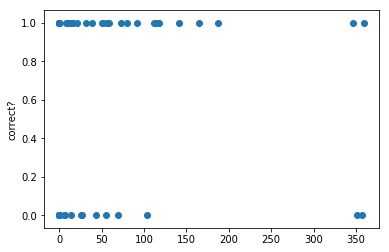

In [234]:
plt.figure()
plt.ylabel('correct?')
plt.scatter(validated_label_features['heading_range'], validated_label_features['correct'])

## Correlation Matrix

<IPython.core.display.Javascript object>


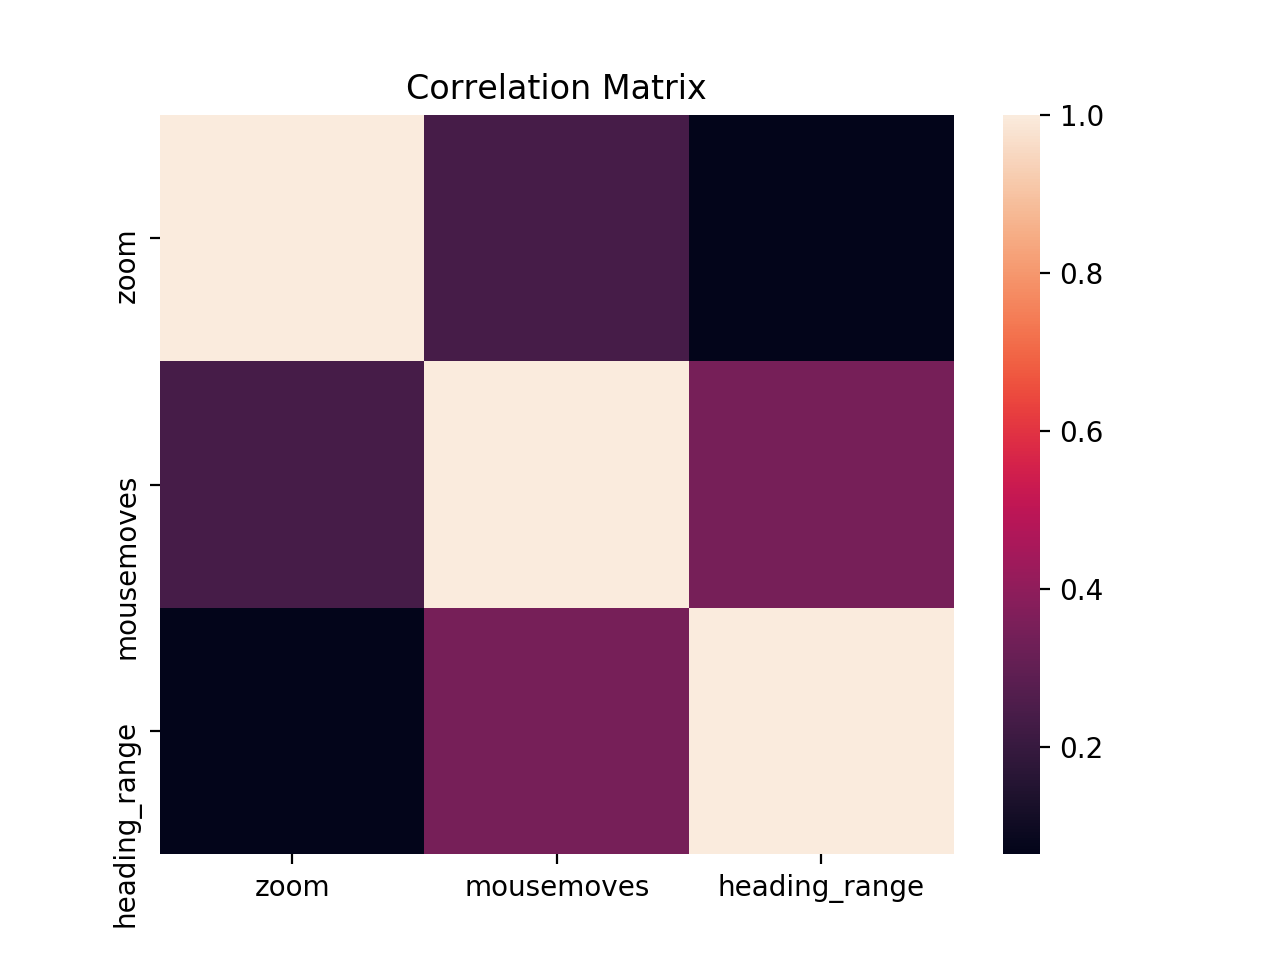

In [238]:
plt.figure()
plt.title('Correlation Matrix')
sns.heatmap(validated_label_features.corr())

<IPython.core.display.Javascript object>


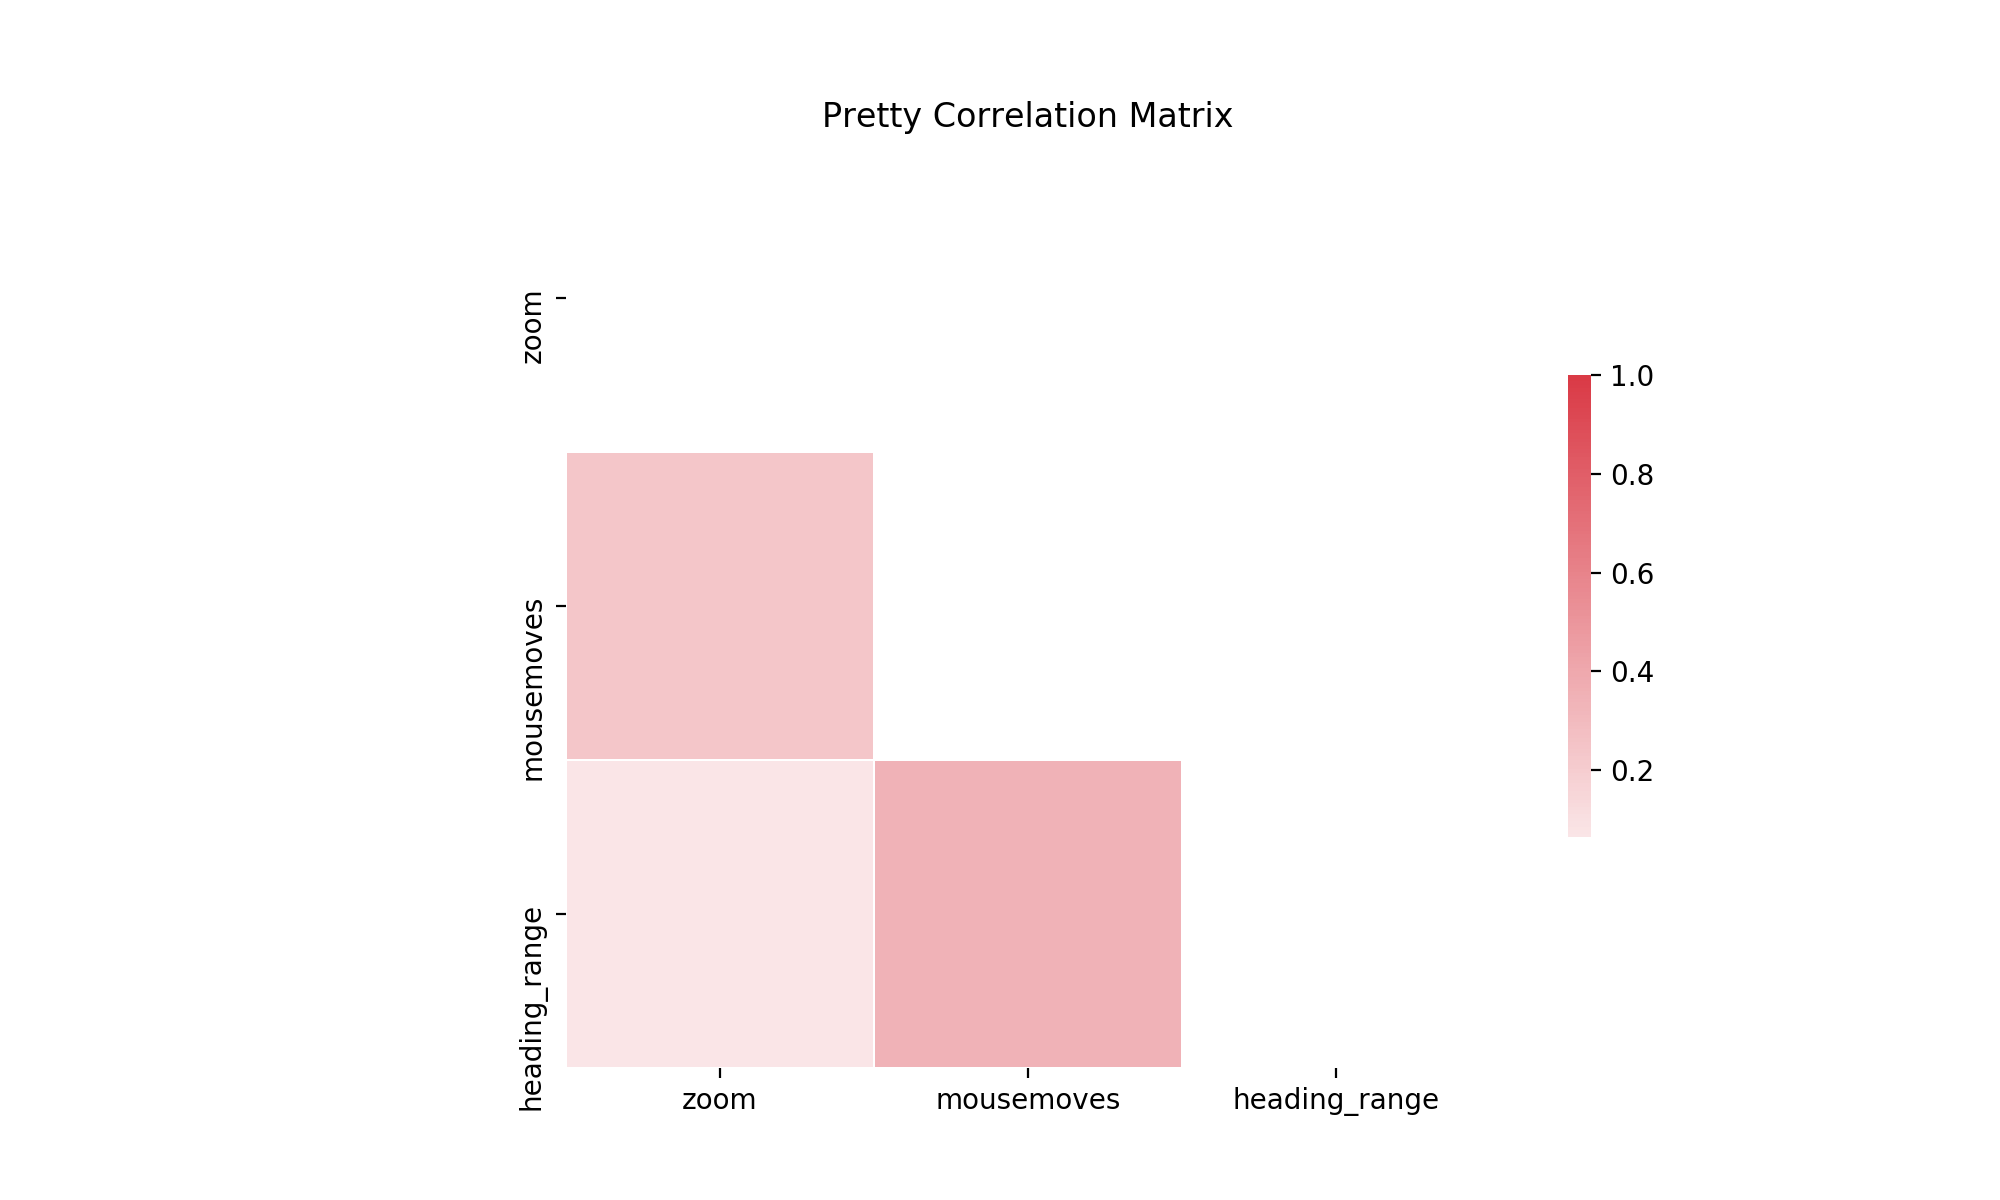

In [239]:
# Compute the correlation matrix
corr = validated_label_features.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from (mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Pretty Correlation Matrix')
# Generate a custom diverging colormap
cmap = sns.diverging_palette (220, 10, as_cmap=True)
# Draw heatmap w/the mask & correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5,cbar_kws={"shrink":.5})